# Project: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper being replicated (the source of the dataset that we'll be using) is available here" https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the modle architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.0525



## Confirm access to a GPU

In [1]:
!python --version

Python 3.10.12


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-da080272-33d0-414b-27a4-91d0e32e1108)


## Get data

Since we'll be replicating the paper bove (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
#Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
#Check all of the filenmaes in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now, let's write a function to read in all of the lines of a target text file

In [7]:
#Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename

  """
  with open(filename,"r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") #read the lines of the training set
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040


How would our data be best represented...

```
[{'line_number': 0,
  'target': BACKGROUND,
  'text':'Emotional eating is associated with overeating and danger of obesity.\n'
  'total_lines':11},
  ...]
```

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filnename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, how many sentences are in the current abstract
  and what sentence number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
       ##check to see if the line is an ID line
       abstract_id = line
       abstract_lines = '' #reset the abstract string if the line is an ID line

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() #Split abstract into separate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] #get target label
        line_data['text'] = target_text_split[1].lower() #get target text
        line_data['line_number'] = abstract_line_number #what number line does the line appear
        line_data['total_lines'] = len(abstract_line_split)-1 #hoe many total lines are there in the target abstract (start)
        abstract_samples.append(line_data) #add line data to abstract samples list

    else:
       # if the above conditionas arent fulfilled, the line contains a labelled sentence
      abstract_lines +=line


  return abstract_samples



In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples),len(val_samples),len(test_samples)


CPU times: user 729 ms, sys: 131 ms, total: 860 ms
Wall time: 1.64 s


(180040, 30212, 30135)

In [12]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
#Distribution of labels in the training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

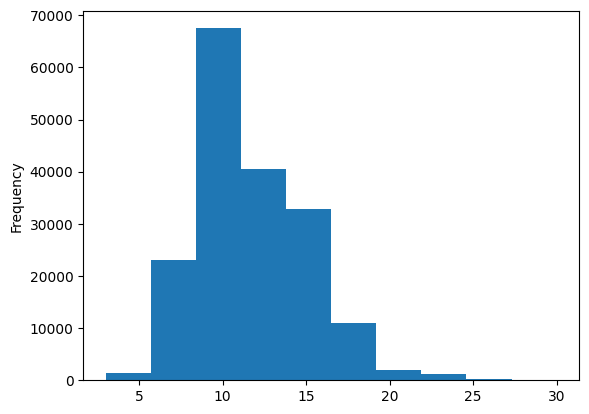

In [15]:
#Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [16]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [18]:
# One hot encode lables
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # We want non sparse matrix for tensroflow conversion
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [19]:
# Extract labels ('target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [21]:
#Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

We are going to be trying out a bunch of different models and seeing which one works best.
We will start with a baseline(TF_IDF Multinomial Naive Bayes classifier)

## Model 0: Getting a baseline using Naive Bayes Classifier


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Creat a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
#Evaluate baseline model validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script


In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-21 14:22:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-21 14:22:43 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
from helper_functions import calculate_results

In [27]:
#Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers:

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

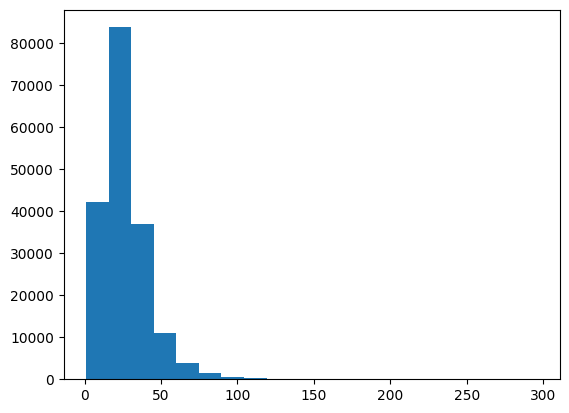

In [31]:
#What's the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [32]:
#How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [33]:
# Maximum sequence length in training set
max(sent_lens)

296

### Create text vectorizer layer
We want to make a lyer which maps our text from words to numbers

In [34]:
#How many words are in our vocab? (taken from table 2 in PubMed20K)
max_tokens = 68000

In [35]:
# Create text vecotrizer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_tokens, # no of wordds in vocab
                                    output_sequence_length=output_seq_len) #desired output length of vectorized sequences

In [36]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [37]:
#Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text
patients in the mct arm had significantly longer pfs ( median @ days , @ % ci : @-@ @ days ) compared to the ip arm ( median @ days , @ % ci ; @-@ @ days ) ( p = @ ) .

Length of text: 46

Vectorized text: [[  12    5    2 5987  207   55   39  583  865  193   84   50   84   34
     6    2 4071  207  193   84   50   84   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [38]:
#How many words in our training vocabilary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Lease common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Lease common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [40]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #length of vocabulary
                               output_dim = 128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths
                               name="token_embedding")

In [41]:
#Show example mebedding
print(f'Sentence before vectorization: \n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
patients in the mct arm had significantly longer pfs ( median @ days , @ % ci : @-@ @ days ) compared to the ip arm ( median @ days , @ % ci ; @-@ @ days ) ( p = @ ) .

Sentence after vectorization (before embedding):
 [[  12    5    2 5987  207   55   39  583  865  193   84   50   84   34
     6    2 4071  207  193   84   50   84   14    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.00118535 -0.03916727 -0.01789613 ...  0.03396958 -0.04025076
   -0.01873393]
  [ 0.00283595  0.01767193  0.0374305  ...  0.03874889  0.02694991
   -0.04698816]
  [ 0.00272558  0.0069515   0.0034765  ... -0.00095429  0.01449171
   -0.00312666]
  ...
  [ 0.02543168  0.01236706  0.02263783 ... -0.03417062 -0.00132871
   -0.02739687]
  [ 0.02543168  0.01236706  0.02263783 ... -0.03417062 -0.00132871
   -0.02739687]
  [ 0.02543168 

## Creating datasets (making sure our data loads as fast as possible)

In [42]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
#Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1:Conv1D with token embeddings

In [44]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) #create embedding
x= layers.Conv1D(64, kernel_size = 5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) #condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                                                    epochs = 3,
                                                    validation_data = valid_dataset,
                                                    validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 44ms/step - loss: 0.9111 - accuracy: 0.6425 - val_loss: 0.6819 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6609 - accuracy: 0.7529 - val_loss: 0.6308 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6219 - accuracy: 0.7710 - val_loss: 0.6014 - val_accuracy: 0.7832


In [47]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6044 - accuracy: 0.7854


[0.6044155955314636, 0.7853832840919495]

In [48]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[3.9128211e-01, 1.7817573e-01, 1.0494546e-01, 2.9155785e-01,
        3.4038898e-02],
       [4.4056317e-01, 2.8789261e-01, 1.2182715e-02, 2.5187466e-01,
        7.4868775e-03],
       [1.6599178e-01, 9.5389159e-03, 2.5577196e-03, 8.2186103e-01,
        5.0523213e-05],
       ...,
       [4.2250354e-06, 6.9966301e-04, 8.6009095e-04, 2.3799530e-06,
        9.9843365e-01],
       [6.8053469e-02, 4.7387376e-01, 8.3781391e-02, 7.8727953e-02,
        2.9556346e-01],
       [1.6606522e-01, 6.6877288e-01, 3.4037869e-02, 4.8541963e-02,
        8.2582086e-02]], dtype=float32)

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.53832914073878,
 'precision': 0.7823875135858877,
 'recall': 0.7853832914073878,
 'f1': 0.7830470131519535}

## Model 2: Feature extraction model with pretrained token embeddings

Training our own embeddings slows experiments down due to training time.
Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub. (as GloVe embeddings are not available in TensorFlow Hub)

The model structure will look like:
`
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
`

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [52]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
whole body vibration increased the expression of the transcription factor peroxisome proliferator receptor gamma coactivator-@ - and serum levels of irisin , while it decreased serum interleukin-@ .

Sentence after embedding:
[ 0.04948126 -0.02126929 -0.03185008 -0.0231687   0.04576283  0.05819547
  0.01192836 -0.00242362  0.0785922   0.07108901  0.04305159  0.00971805
  0.02853836  0.05485063 -0.0411852  -0.0770981  -0.04200179 -0.04832074
  0.07182052  0.03986818 -0.02263088  0.03098972  0.03397212  0.08180174
 -0.07514504  0.04758853  0.01889179 -0.03300761 -0.02274919  0.07493155] (truncated output)...

Length of sentence embedding:
512


The pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

Let's put together and compile a model using our tf_hub_embedding_layer

### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [53]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [54]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set training=False when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [55]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9132 - accuracy: 0.6508 - val_loss: 0.7948 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7665 - accuracy: 0.7035 - val_loss: 0.7534 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7488 - accuracy: 0.7124 - val_loss: 0.7382 - val_accuracy: 0.7138


In [56]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7388 - accuracy: 0.7147


[0.7387767434120178, 0.714682936668396]

Since we aren't training our own custom embedding layer, training is much quicker.

Let's make some predictions and evaluate our feature extraction model.

In [57]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.4126526e-01, 3.3744517e-01, 2.0192107e-03, 2.1204223e-01,
        7.2280099e-03],
       [3.2269076e-01, 5.0865626e-01, 3.2657590e-03, 1.6246681e-01,
        2.9204574e-03],
       [2.2170810e-01, 1.3623472e-01, 2.3534065e-02, 5.8126789e-01,
        3.7255187e-02],
       ...,
       [1.4347126e-03, 6.3321837e-03, 4.6007577e-02, 8.3826383e-04,
        9.4538724e-01],
       [4.8030145e-03, 5.2081916e-02, 2.4195468e-01, 1.7637955e-03,
        6.9939655e-01],
       [1.5537815e-01, 2.7777475e-01, 4.8538297e-01, 6.5720617e-03,
        7.4891992e-02]], dtype=float32)

In [58]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [59]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.46829074539917,
 'precision': 0.7151556108073758,
 'recall': 0.7146829074539918,
 'f1': 0.7117095191172709}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

 *Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.*

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the TextVectorization class and then passing those vectorized sequences through an Embedding layer.

In [60]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'w h o l e   b o d y   v i b r a t i o n   i n c r e a s e d   t h e   e x p r e s s i o n   o f   t h e   t r a n s c r i p t i o n   f a c t o r   p e r o x i s o m e   p r o l i f e r a t o r   r e c e p t o r   g a m m a   c o a c t i v a t o r - @   -   a n d   s e r u m   l e v e l s   o f   i r i s i n   ,   w h i l e   i t   d e c r e a s e d   s e r u m   i n t e r l e u k i n - @   .'

In [61]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [62]:

# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

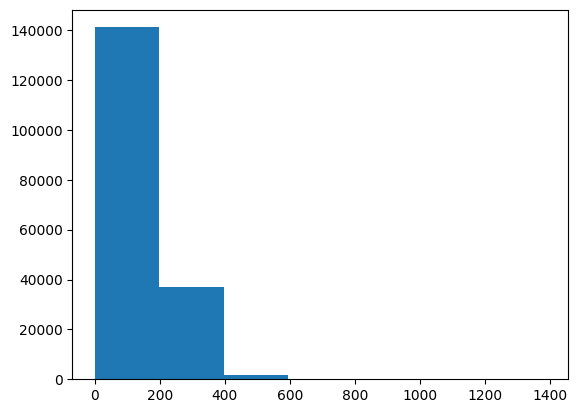

In [63]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len


290


Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [65]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [67]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 2
5 most common characters: ['', '[UNK]']
5 least common characters: ['', '[UNK]']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
char_vectorizer.adapt(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
o f   @   p a r t i c i p a n t s   s c r e e n e d   ,   @   w e r e   f o u n d   t o   b e   i n e l i g i b l e   ,   a n d   @   d e c l i n e d   p a r t i c i p a t i o n   .

Length of chars: 75

Vectorized chars:
[[ 7 17 14  5  8  3  4 11  4 14  5  6  3  9  9 11  8  2  2  6  2 10 20  2
   8  2 17  7 16  6 10  3  7 22  2  4  6  2 12  4 18  4 22 12  2  5  6 10
  10  2 11 12  4  6  2 10 14  5  8  3  4 11  4 14  5  3  4  7  6  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

### Create a character level embedding

We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the tensorflow.keras.layers.Embedding class.

The input dimension (input_dim) will be equal to the number of different characters in our char_vocab (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (output_dim) will be 25.

In [69]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
o f   @   p a r t i c i p a n t s   s c r e e n e d   ,   @   w e r e   f o u n d   t o   b e   i n e l i g i b l e   ,   a n d   @   d e c l i n e d   p a r t i c i p a t i o n   .

Embedded chars (after vectorization and embedding):
[[[-0.02888516 -0.03061296  0.02661249 ... -0.01029157  0.02356155
    0.03360328]
  [ 0.00792297 -0.02023435 -0.01822834 ...  0.03975871 -0.00834017
   -0.03599668]
  [ 0.04047329 -0.0450539  -0.0286794  ...  0.0424026   0.03256667
   -0.04980518]
  ...
  [-0.02535359  0.01431204  0.0062024  ...  0.04275883 -0.01838417
    0.01256254]
  [-0.02535359  0.01431204  0.0062024  ...  0.04275883 -0.01838417
    0.01256254]
  [-0.02535359  0.01431204  0.0062024  ...  0.04275883 -0.01838417
    0.01256254]]]

Character embedding shape: (1, 290, 25)


###Building a Conv1D model to fit on character embeddings

Now we've got a way to turn our character-level sequences into numbers (char_vectorizer) as well as numerically represent them as an embedding (char_embed) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

`Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)`

In [70]:
input = layers.Input(shape=(1,),dtype="string")
char_vectors =  char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [72]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [73]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2673 - accuracy: 0.4923 - val_loss: 1.0333 - val_accuracy: 0.5938
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9913 - accuracy: 0.6098 - val_loss: 0.9271 - val_accuracy: 0.6293
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9175 - accuracy: 0.6396 - val_loss: 0.8515 - val_accuracy: 0.6792


In [74]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8731 - accuracy: 0.6589


[0.8731107115745544, 0.6589434742927551]

In [75]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.08655904, 0.36497393, 0.32727084, 0.13406806, 0.08712823],
       [0.1234552 , 0.5592279 , 0.02440272, 0.22773987, 0.06517442],
       [0.04634231, 0.39923552, 0.15289538, 0.25898904, 0.14253779],
       ...,
       [0.01817567, 0.04686133, 0.06931734, 0.01953673, 0.8461089 ],
       [0.05054266, 0.11293077, 0.427748  , 0.03397525, 0.3748033 ],
       [0.38105687, 0.45322385, 0.06982011, 0.08868258, 0.00721655]],
      dtype=float32)

In [76]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 1])>

In [77]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.89434661723818,
 'precision': 0.6494068866286927,
 'recall': 0.6589434661723819,
 'f1': 0.6484096341696598}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating (or getting close to replicating) to the original model in the research paper, we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [78]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [79]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

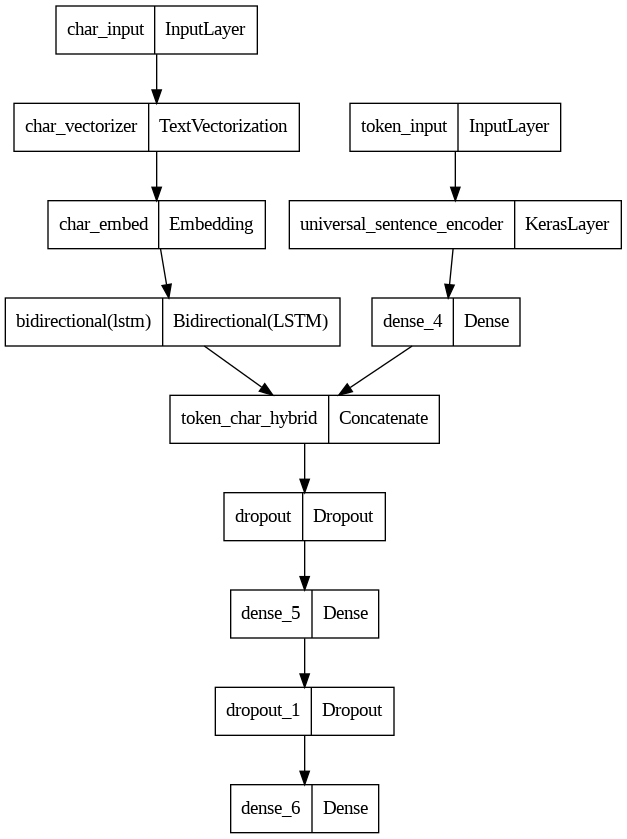

In [80]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [81]:

# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])


In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences

In [84]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 35ms/step - loss: 0.9636 - accuracy: 0.6169 - val_loss: 0.7721 - val_accuracy: 0.7018
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.7916 - accuracy: 0.6934 - val_loss: 0.7124 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7692 - accuracy: 0.7099 - val_loss: 0.6848 - val_accuracy: 0.7404


In [85]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6903 - accuracy: 0.7370


[0.6903095841407776, 0.7369919419288635]

In [86]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 18ms/step


array([[4.6041411e-01, 3.2244444e-01, 3.1836343e-03, 2.0811723e-01,
        5.8405665e-03],
       [3.5223770e-01, 4.7264981e-01, 3.3295874e-03, 1.6908540e-01,
        2.6974238e-03],
       [3.1454191e-01, 1.8902738e-01, 5.3893849e-02, 4.0964529e-01,
        3.2891523e-02],
       ...,
       [6.9383066e-04, 1.0803399e-02, 4.2773981e-02, 2.4667746e-04,
        9.4548208e-01],
       [7.1902848e-03, 4.1188847e-02, 2.1195523e-01, 3.4496074e-03,
        7.3621601e-01],
       [2.7664900e-01, 3.2973740e-01, 3.2245117e-01, 3.3148762e-02,
        3.8013652e-02]], dtype=float32)

In [87]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [88]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.69919237389117,
 'precision': 0.7367470813518523,
 'recall': 0.7369919237389116,
 'f1': 0.7347088017394849}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

Abstracts typically come in a sequential order, such as:

* OBJECTIVE ...
* METHODS ...
* METHODS ...
* METHODS ...
* RESULTS ...
* CONCLUSIONS ...

Or

* BACKGROUND ...
* OBJECTIVE ...
* METHODS ...
* METHODS ...
* RESULTS ...
* RESULTS ...
* CONCLUSIONS ...
* CONCLUSIONS ...

We can encode the order of a set of sequences in an abstract.

For example,

* Sentence 1 of 10 ...
* Sentence 2 of 10 ...
* Sentence 3 of 10 ...
* Sentence 4 of 10 ...


In [89]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings
Let's create positional embeddings using `line_number` and `total_lines` columns

To avoid our model thinking a line with "line_number"=5 is five times greater than a line with "line_number"=1, we'll use one-hot-encoding to encode our "line_number" and "total_lines" features.


In [90]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

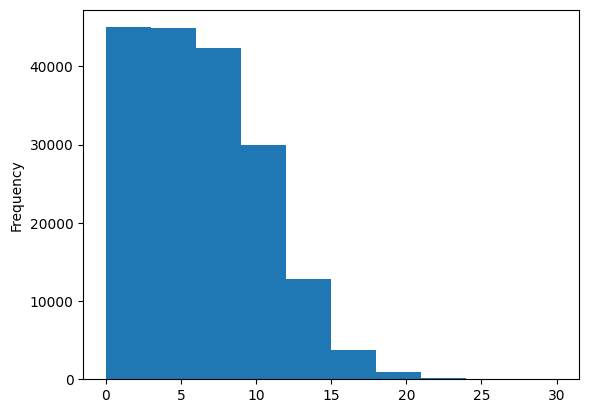

In [91]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Majority of lines have a position of 15 or less.

Let's set the depth parameter of tf.one_hot to 15

In [92]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [93]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We can do the same as we've done for our `"line_number"` column witht he `"total_lines"` column. First, let's find an appropriate value for the depth parameter of tf.one_hot

In [94]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

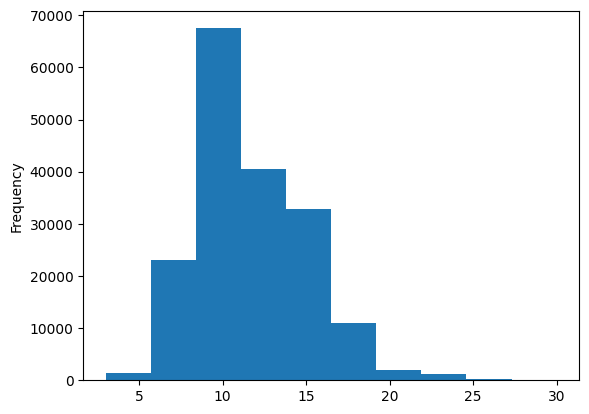

In [95]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our "total_lines" column, a value of 20 looks like it covers the majority of samples.

In [96]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


In [97]:
# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

##Building a tribrid embedding model
The steps are:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [98]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [99]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

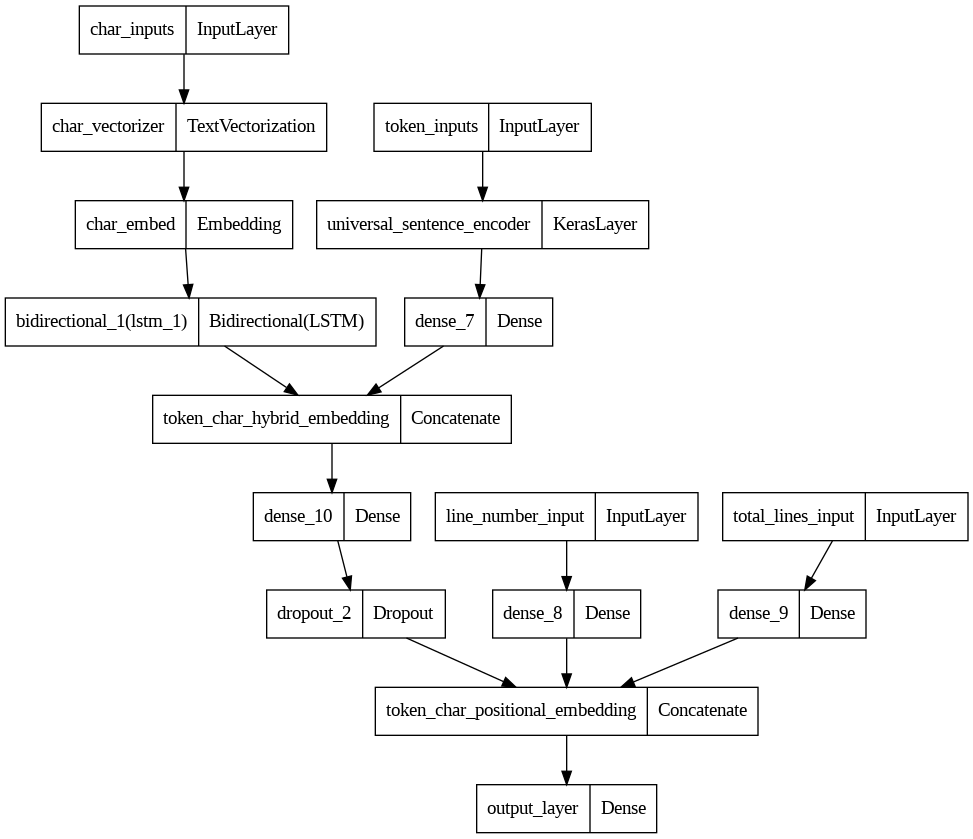

In [100]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [101]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c5f3fb14310> True
<keras.src.engine.input_layer.InputLayer object at 0x7c5f3fafe680> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7c5ea49c23b0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7c5f37098370> False
<keras.src.layers.core.embedding.Embedding object at 0x7c5ea49ec280> True
<keras.src.layers.core.dense.Dense object at 0x7c5f3fb141c0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7c5f3fc878b0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7c5f3fbb3340> True
<keras.src.engine.input_layer.InputLayer object at 0x7c5f3fafc280> True
<keras.src.engine.input_layer.InputLayer object at 0x7c5f3fb383d0> True
<keras.src.layers.core.dense.Dense object at 0x7c5f3fa2ad10> True
<keras.src.layers.core.dense.Dense object at 0x7c5f3fafc490> True
<keras.src.layers.core.dense.Dense object at 0x7c5f3fcd4640> True
<keras.src.layers.regularization.dropout.

In [102]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

##Create tribrid embedding datasets and fit tribrid model
Now, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

1. Train line numbers one-hot tensor `(train_line_numbers_one_hot)`
2. Train total lines one-hot tensor `(train_total_lines_one_hot)`
3. Token-level sequences tensor `(train_sentences)`
4. Char-level sequences tensor `(train_chars)`
We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched Prefetched Dataset's.

In [103]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [104]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 37ms/step - loss: 1.0954 - accuracy: 0.7222 - val_loss: 0.9875 - val_accuracy: 0.7972
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.9708 - accuracy: 0.8142 - val_loss: 0.9509 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9538 - accuracy: 0.8219 - val_loss: 0.9406 - val_accuracy: 0.8301


In [105]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 24s 25ms/step


array([[0.4768406 , 0.11761573, 0.01354679, 0.37340137, 0.01859556],
       [0.5234888 , 0.11924624, 0.04373302, 0.30066904, 0.01286292],
       [0.30481428, 0.10861873, 0.140752  , 0.3809327 , 0.06488225],
       ...,
       [0.033899  , 0.11388335, 0.03634101, 0.03071527, 0.78516144],
       [0.03255206, 0.24495411, 0.07680792, 0.028644  , 0.6170419 ],
       [0.18892935, 0.6318742 , 0.08510756, 0.04106313, 0.05302574]],
      dtype=float32)

In [106]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [107]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 83.03985171455051,
 'precision': 0.8295746589075318,
 'recall': 0.830398517145505,
 'f1': 0.8293071069807878}

##Compare model results
Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them

In [108]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.538329,0.782388,0.785383,0.783047
pretrained_token_embed,71.468291,0.715156,0.714683,0.711710
custom_char_embed_conv1d,65.894347,0.649407,0.658943,0.648410
hybrid_char_token_embed,73.699192,0.736747,0.736992,0.734709
tribrid_pos_char_token_embed,83.039852,0.829575,0.830399,0.829307


In [109]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

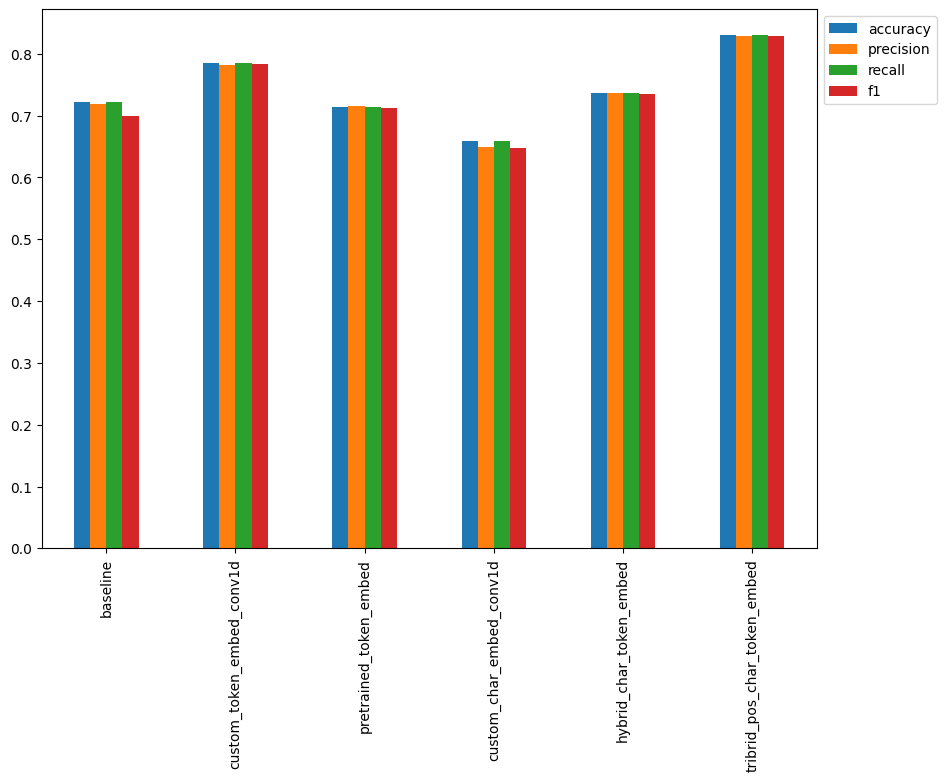

In [110]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

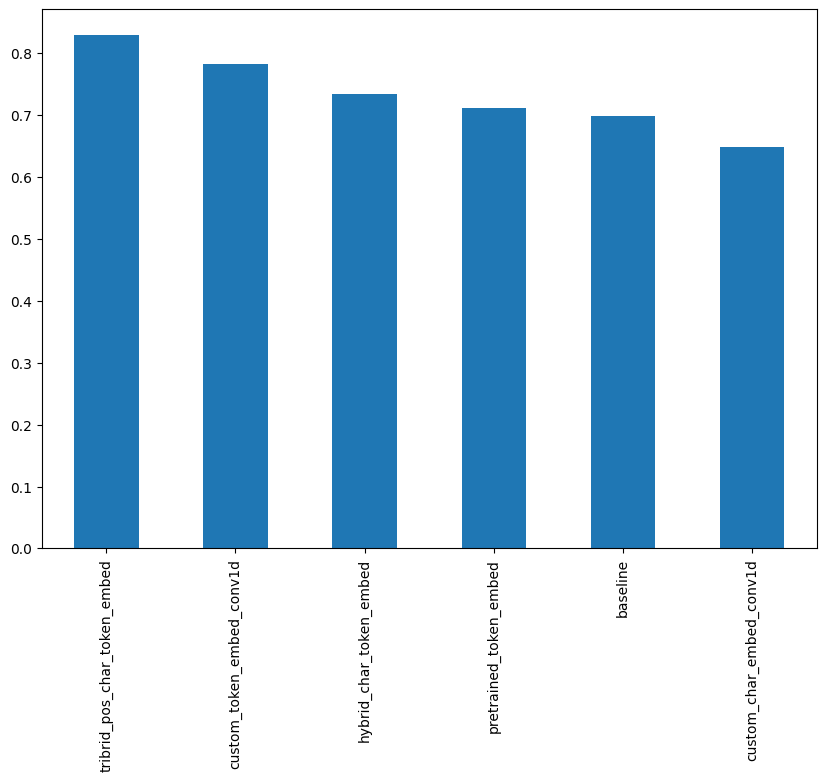

In [111]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

##Save and load best performing model
Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain it.

We can save our best performing model by calling the save() method on it.

In [112]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [113]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-04-21 14:30:12--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  63.3MB/s    in 14s     

2024-04-21 14:30:26 (66.0 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/sk

In [114]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

##Make predictions and evalaute them against the truth labels
To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [115]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]


945/945 [==============================] - 18s 17ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [116]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [117]:
#Compare loaded model results with original trained model results (should be smmilar)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [118]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

## Evaluate model on test dataset
To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [119]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [120]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 18s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [121]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

##Make example predictions

For each abstract, we'll need to:

1. Split it into sentences (lines).
2. Split it into characters.
3. Find the number of each line.
4. Find the total number of lines.

In [122]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-04-21 14:31:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-04-21 14:31:29 (74.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [123]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [124]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [125]:

# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines


[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [126]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [127]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [128]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [129]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.12 s, sys: 17 ms, total: 1.14 s
Wall time: 1.11 s


array([[0.26448247, 0.11054241, 0.01762423, 0.5750656 , 0.03228523],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940544],
       [0.13772687, 0.04937517, 0.5467969 , 0.1634129 , 0.10268807],
       [0.09659053, 0.17111638, 0.52574396, 0.0760164 , 0.13053276],
       [0.04459697, 0.08888115, 0.4567545 , 0.04623033, 0.36353707],
       [0.03265215, 0.14626427, 0.51748496, 0.04088319, 0.26271546],
       [0.03290153, 0.1779621 , 0.07166822, 0.02870873, 0.6887594 ],
       [0.01843721, 0.13495171, 0.32084197, 0.03389723, 0.49187192]],
      dtype=float32)

In [130]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [131]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [132]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Let's try with a different abstract

In [133]:
doc = nlp(example_abstracts[1]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
 "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
 "Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.",
 "Vitamin D: no relevant RCT's were identified, however seven observational studies o

In [134]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
  'line_number': 2,
  'total_lines': 9},
 {'text': "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
  'line_number': 3,
  'total_lines': 9},
 {'

In [135]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [136]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
     

In [137]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['P o s t p a r t u m   d e p r e s s i o n   ( P P D )   i s   t h e   m o s t   p r e v a l e n t   m o o d   d i s o r d e r   a s s o c i a t e d   w i t h   c h i l d b i r t h .',
 'N o   s i n g l e   c a u s e   o f   P P D   h a s   b e e n   i d e n t i f i e d ,   h o w e v e r   t h e   i n c r e a s e d   r i s k   o f   n u t r i t i o n a l   d e f i c i e n c i e s   i n c u r r e d   t h r o u g h   t h e   h i g h   n u t r i t i o n a l   r e q u i r e m e n t s   o f   p r e g n a n c y   m a y   p l a y   a   r o l e   i n   t h e   p a t h o l o g y   o f   d e p r e s s i v e   s y m p t o m s .',
 'T h r e e   n u t r i t i o n a l   i n t e r v e n t i o n s   h a v e   d r a w n   p a r t i c u l a r   i n t e r e s t   a s   p o s s i b l e   n o n - i n v a s i v e   a n d   c o s t - e f f e c t i v e   p r e v e n t i o n   a n d / o r   t r e a t m e n t   s t r a t e g i e s   f o r   P P D ;   o m e g a - 3   ( n - 3 )   l o n g   c h a i n   p o l y u 

In [138]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 0s 76ms/step
CPU times: user 138 ms, sys: 1.11 ms, total: 139 ms
Wall time: 196 ms


array([[0.3353021 , 0.04649478, 0.06660887, 0.4213718 , 0.13022247],
       [0.46066839, 0.08873837, 0.08032792, 0.28913954, 0.08112584],
       [0.33493942, 0.1608067 , 0.22624324, 0.24154742, 0.03646319],
       [0.08900189, 0.0995165 , 0.6342368 , 0.09420796, 0.08303691],
       [0.11460999, 0.1632036 , 0.27615854, 0.10356896, 0.34245893],
       [0.06432986, 0.16912176, 0.16241749, 0.06797509, 0.5361558 ],
       [0.05155892, 0.2215055 , 0.33480257, 0.06219135, 0.32994166],
       [0.03721163, 0.2532911 , 0.07278129, 0.0618933 , 0.57482266],
       [0.05528113, 0.80441356, 0.03319721, 0.05017553, 0.05693261],
       [0.03818994, 0.4481141 , 0.09110532, 0.04597459, 0.37661606]],
      dtype=float32)

In [139]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 0, 2, 4, 4, 2, 4, 1, 1])>

In [140]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [141]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.
BACKGROUND: No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.
BACKGROUND: Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.
METHODS: We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.
RESULTS: Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.
RESULTS: Vitamin D: no relevant RCT's were identifie